# runningmeans

This is the second step in reproducing the cluster analysis from Sara and David following Amini et al 2019
https://doi.org/10.1007/s00382-018-4409-7

This program:
1. Reads data:
* Input File: `/glade/work/mkorendy/metisregimes/era5.z500_pna_NDJFM_twicedaily.1980-2019.nc`
* Input File: `/glade/work/mkorendy/metisregimes/era5.u250_pna_NDJFM_twicedaily.1980-2019.nc`
2. Sorts data and time to be in chronological order
3. Makes 5-day running means
4. Extracts data for 19801201 to 20190301
5. Writes data to single netcdf file containing both variables
* Output File: `/glade/work/mkorendy/metisregimes/era5.z500_u250_pna_5dyrm_NDJFM_twicedaily.1980-2019.nc`

### Function to calculate the running running mean over the season from November 1 to March 31 1980-2019

In [2]:
def rm_season(da,window,yrs_list,varname):

    nt,ny,nx=da.shape
    ndays=149
    nyr=int(nt/ndays)
    
    # Create empty list to store each years 5-day running mean
    ds_rm_tmp=[]
    
    # Loop over all years
    for yr in yrs_list:
         
        # Define the start date as November 1st and the end date to get
        # a total of 149 days
        start_date=pd.to_datetime(str(yr)+'1101')
        end_date=start_date+pd.DateOffset(days=ndays) + pd.DateOffset(hours=12)
        
        # Select just the 149 days
        ds_this_year=da.sel(time=slice(start_date,end_date))
        #print(ds_this_year)
        #print(ds_this_year.rolling(time=window,center=True))
        #print(ds_this_year.rolling(time=window,center=True).mean().dropna(dim='time'))
        
        # Calculate the running mean & append to list
        ds_rm_tmp.append(ds_this_year.rolling(time=window,center=True).mean().dropna(dim='time'))

    # Combine each year's 5-day running mean together in the time index and convert to xarray.Dataset
    ds_rm = xr.combine_nested(ds_rm_tmp, concat_dim='time').to_dataset(name=varname)
    
    # Return the xarray.Dataset
    return ds_rm

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
yrs_list=np.arange(1980,2020)

### Define input and output files

In [5]:
# Input
path='/glade/work/mkorendy/metisregimes/'
f_z='era5.z500_pna_NDJFM_twicedaily.1980-2019.nc'
f_u='era5.u250_pna_NDJFM_twicedaily.1980-2019.nc'

# Output
ofname='era5.z500_u250_pna_5dyrm_NDJFM_twicedaily.1980-2019.nc'
outfile=path+ofname

### Read the data

In [6]:
ds_z=xr.open_dataset(path+f_z,decode_times=True)
#ds_z

In [7]:
ds_u=xr.open_dataset(path+f_u,decode_times=True)
#ds_u

In [12]:
ds = xr.merge([ds_z,ds_u])
#ds

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 14580)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-12-31T12:00:00
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...

### Put data in consecutive order

In [14]:
#ds=ds.reindex(time=sorted(ds['time'].values))

### Quick look plots

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 2)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * time     (time) datetime64[ns] 1980-12-03 1980-12-03T12:00:00
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...


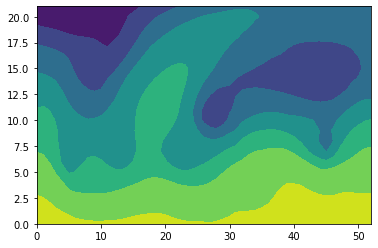

In [15]:
tmp=ds.sel(time='19801203')
print(tmp)
plt.contourf(tmp['z500'][0,::-1,:])

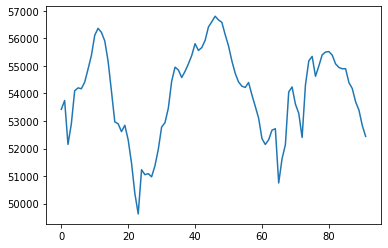

In [16]:
plt.plot(ds['z500'][0:92,12,25])

### Calculate the 5-day running means for Z500 and U250 and combine them together in the same `xarray.Dataset`

In [17]:
z500_rm=rm_season(ds['z500'],5,yrs_list,'z500')
u250_rm=rm_season(ds['u250'],5,yrs_list,'u250')
ds_5dayrm=xr.merge([z500_rm,u250_rm])
#print(z500_rm)

In [18]:
#ds_5dayrm

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 13984)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * time     (time) datetime64[ns] 1980-11-02 ... 2019-12-30T12:00:00
Data variables:
    z500     (time, lat, lon) float64 5.076e+04 5.083e+04 ... 5.77e+04 5.763e+04
    u250     (time, lat, lon) float64 -3.101 -3.222 -3.08 ... 8.534 9.595 9.217

### Quick look plots

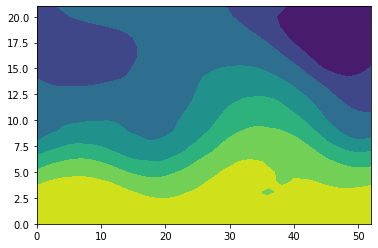

In [19]:
plt.contourf(ds_5dayrm['z500'][0,::-1,:])

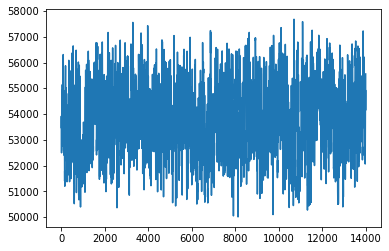

In [20]:
plt.plot(ds_5dayrm['z500'][:,12,25])

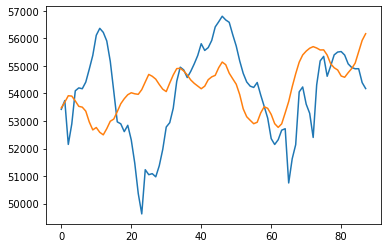

In [21]:
plt.plot(ds['z500'][0:88,12,25])
plt.plot(ds_5dayrm['z500'][0:88,12,25])

### Write to netcdf

In [22]:
ds_5dayrm.to_netcdf(outfile)